### PROJETO: DETECÇÃO DE FRAUDES NO TRÁFEGO DE CLIQUES EM PROPAGANDAS DE APLICAÇÕES MOBILE - TALKINGDATA

### DESCRIÇÃO DOS DADOS

Os dados de treino foram coletados do dataset train.csv do Kaggle. Além de coletar amostras, foram realizadas modificações nos nomes das variáveis para uma melhor compreensão delas.

Dados de Treino:

Cada linha dos dados de treinamento contém um registro de cliques, com os seguintes recursos.

- ip: ip endereço de clique.
- app: id de aplicativo para marketing.
- dispositivo: identificação do tipo de dispositivo do celular do usuário (por exemplo, iphone 6 plus, iphone 7, huawei mate 7, etc.)
- so: id versão do sistema operacional do celular do usuário
- canal: id do canal da editora de anúncios móveis
- horario-clique: fuso de hora em hora (UTC)
- horario-download: se o usuário baixar o aplicativo para depois de clicar em um anúncio, esta é a hora do download do aplicativo
- classe: o alvo a ser previsto, indicando que o aplicativo foi baixado (não fraude = 1) ou não baixado (fraude = 0).

### PRÉ-PROCESSAMENTO

#### CARREGAR BIBLIOTECAS

In [1]:
# DESATIVAR MENSAGENS DE WARNINGS (warn = -1) E ATIVAR (warn = 0)
options(warn = -1)

In [2]:
# DESATIVA NOTAÇÃO CIENTÍFICA
options(scipen = 999)

In [3]:
# PARA TAMANHO DOS GRÁFICOS
options(jupyter.plot_scale = 1)

In [4]:
# CARREGANDO BIBLIOTECAS 
suppressPackageStartupMessages({
library(dplyr)
library(tidyr)
library(data.table)
library(readr)
library(ggplot2)
library(gridExtra)
library(scales) # Função date_format()
library(lubridate)
library(caret)
library(xgboost)
library(e1071)
library(class)
library(caTools) # Função sample.split()
library(ROCR)
})

#### CARREGAR DADOS

In [5]:
# CARREGAR df_Talking_Data
df_talkingdata <- fread("df-talkingdata.csv")
glimpse(df_talkingdata)

Rows: 240,000
Columns: 8
$ ip               <int> 159048, 191117, 10833, 113682, 6534, 130391, 286692, ~
$ app              <int> 39, 18, 20, 6, 9, 10, 190, 19, 12, 19, 8, 12, 3, 10, ~
$ dispositivo      <int> 1, 1, 1, 1, 1, 1, 1, 129, 1, 0, 1, 1, 1, 1, 1, 0, 1, ~
$ so               <int> 14, 10, 10, 17, 13, 61, 18, 24, 32, 24, 19, 13, 19, 7~
$ canal            <int> 213, 376, 259, 459, 489, 113, 213, 213, 259, 213, 145~
$ horario_clique   <dttm> 2017-11-07 02:49:38, 2017-11-07 08:10:07, 2017-11-07~
$ horario_download <dttm> 2017-11-07 02:54:44, NA, NA, NA, NA, 2017-11-07 02:4~
$ classe           <int> 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,~


In [6]:
# TRANSFORMAR COLUNAS DE STRING EM DATA
df_talkingdata$horario_clique <- as_datetime(df_talkingdata$horario_clique)
df_talkingdata$horario_download <- as_datetime(df_talkingdata$horario_download)

In [7]:
glimpse(df_talkingdata)

Rows: 240,000
Columns: 8
$ ip               <int> 159048, 191117, 10833, 113682, 6534, 130391, 286692, ~
$ app              <int> 39, 18, 20, 6, 9, 10, 190, 19, 12, 19, 8, 12, 3, 10, ~
$ dispositivo      <int> 1, 1, 1, 1, 1, 1, 1, 129, 1, 0, 1, 1, 1, 1, 1, 0, 1, ~
$ so               <int> 14, 10, 10, 17, 13, 61, 18, 24, 32, 24, 19, 13, 19, 7~
$ canal            <int> 213, 376, 259, 459, 489, 113, 213, 213, 259, 213, 145~
$ horario_clique   <dttm> 2017-11-07 02:49:38, 2017-11-07 08:10:07, 2017-11-07~
$ horario_download <dttm> 2017-11-07 02:54:44, NA, NA, NA, NA, 2017-11-07 02:4~
$ classe           <int> 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,~


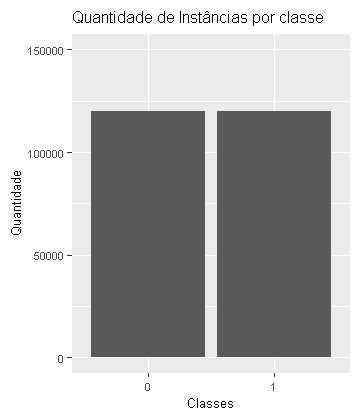

In [8]:
# QUANTIDADE DE INSTÂNCIAS EM CADA CLASSES
g0 <- ggplot(df_talkingdata, aes(x = as.factor(classe))) +
     geom_bar(stat = 'count') +
     coord_cartesian(ylim = c(0, 150000)) +
     labs(title = "Quantidade de Instâncias por classe",x = 'Classes', y = 'Quantidade') +
     theme(text = element_text(size = 8))

options(repr.plot.width = 3.0, repr.plot.height = 3.5)
g0

#### CLIQUES SEM DOWNLOAD

In [9]:
## SLICE DATASET - APLICATIVO NÃO BAIXADO
df_naobaixado <- df_talkingdata[df_talkingdata$classe == 0,]
df_naobaixado$classe <- as.factor(df_naobaixado$classe)

In [10]:
# FUNÇÃO PARA PLOTAGEM DO GRÁFICO DE BARRAS
grafico_barras <- function(x, xlab, title){
    ggplot(x[1:15,], aes(x = reorder(Var1, Freq), y = Freq)) +
    geom_bar(stat = "identity") + labs(x = xlab, y = "Quantidade", title = title) +
    theme_minimal() +
    theme( plot.title = element_text(hjust = 0.5), text = element_text(size = 8)) +
    coord_flip()
}

In [11]:
# IP 
ip <- data.frame(table(df_naobaixado$ip))
ip <- ip[order(ip$Freq, decreasing = T),]

# IP E NÚMERO DE CLIQUES QUE NÃO BAIXARAM O APLICATIVO 
# 15 PRIMEIROS IPs DE MAIOR NÚMERO DE CLIQUES 
g1 = grafico_barras(ip, "IP", "quantidade de cliques sem download por IP")

In [12]:
# ID APP 
id_aplicativo <- data.frame(table(df_naobaixado$app))
id_aplicativo <- id_aplicativo[order(id_aplicativo$Freq, decreasing = T),]

# IDs DE APP E NÚMERO DE CLIQUES QUE NÃO BAIXARAM O APLICATIVO 
# 15 PRIMEIROS IDs DE APP DE MAIOR NÚMERO DE CLIQUES 
g2 = grafico_barras(id_aplicativo, "App", "Quantidade de cliques sem download por App")

In [13]:
# ID DISPOSITIVO
id_dispositivo <- data.frame(table(df_naobaixado$dispositivo))
id_dispositivo <- id_dispositivo[order(id_dispositivo$Freq, decreasing = T),]

# IDs DOS DISPOSITIVOS E VOLUME DE CLIQUES QUE NÃO BAIXARAM O APLICATIVO 
# 15 PRIMEIROS IDs DE DISPOSITIVOS DE MAIOR NÚMERO DE CLIQUES
g3 = grafico_barras(id_dispositivo, "Dispositivo", "Quantidade de cliques sem download por dispositivo")

In [14]:
# ID SISTEMA OPERACIONAL
id_so <- data.frame(table(df_naobaixado$so))
id_so <- id_so[order(id_so$Freq, decreasing = T),]

# IDs DO SISTEMA OPERACIONAL E VOLUME DE CLIQUES QUE NÃO BAIXARAM O APLICATIVO 
# 15 PRIMEIROS IDs DE SISTEMA OPERACIONAL DE MAIOR NÚMERO DE CLIQUES
g4 <- grafico_barras(id_so, "SO", "Quantidade de cliques sem download por SO")

In [15]:
# ID CANAL 
id_canal <- data.frame(table(df_naobaixado$canal))
id_canal <- id_canal [order(id_canal$Freq, decreasing = T),]

# IDs DE CANAL E VOLUME DE CLIQUES QUE NÃO BAIXARAM O APLICATIVO
# 15 PRIMEIROS IDs DE CANAL EM QUE SE TEVE MAIOR NÚMERO DE CLIQUES
g5 <- grafico_barras(id_canal, "Canal", "Quantidade de cliques sem download por canal")

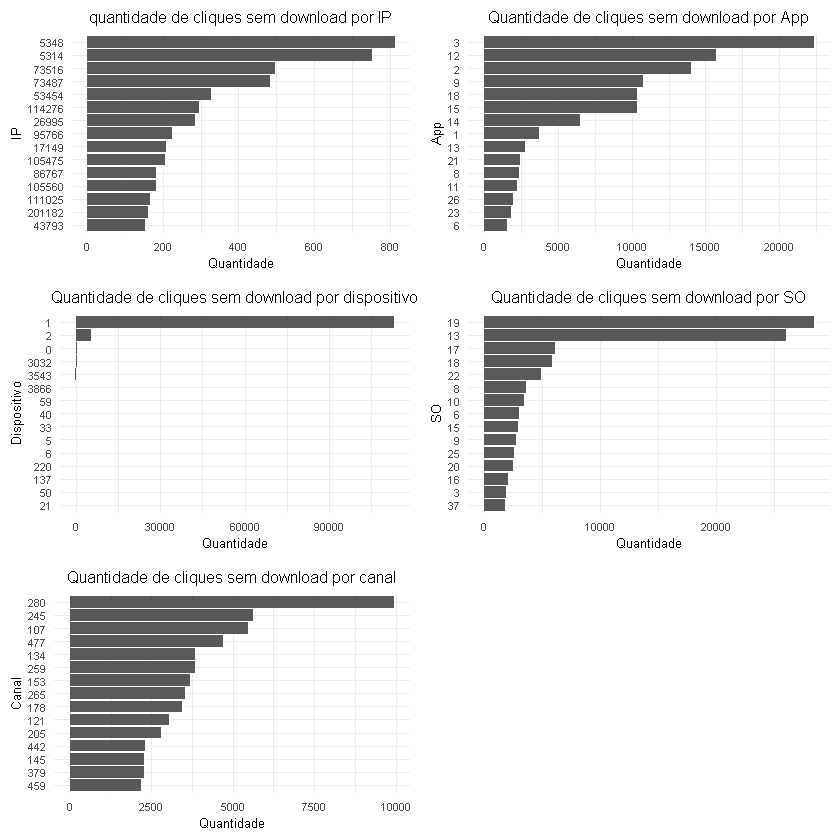

In [16]:
options(repr.plot.width = 7, repr.plot.height = 7)
grid.arrange(g1, g2, g3, g4, g5)

O tipo de dispositivo 1 é o que mais está associado à cliques sem downloads. Os IDs do sistema operacional 19 e 13 são os mais associados à cliques sem downloads. Já o canal em que mais se tem cliques sem downloads é o 280.

In [17]:
# PERÍODO DE CLIQUES SEM DOWNLOAD CONFORME AMOSTRA COLETADA - DATA E HORÁRIO
cliques_naobaixado = df_talkingdata[df_talkingdata$classe == 0,]
inicio <- min(cliques_naobaixado$horario_clique)
fim <- max(cliques_naobaixado$horario_clique)
cat(sprintf("De: %s", inicio))
cat(sprintf("\nAté: %s", fim))

De: 2017-11-06 15:49:03
Até: 2017-11-09 16:00:00

In [18]:
# TABELA COM A FREQUENCIA DE CLIQUES SEM DOWNLOAD EM DETERMINADO HORÁRIO 
df_frequencia1 <- data.frame(table(cliques_naobaixado$horario_clique))
names(df_frequencia1) <- c("data_horario", "frequencia")
head(df_frequencia1, 3)

data_horario,frequencia
2017-11-06 15:49:03,1
2017-11-06 16:00:00,1
2017-11-06 16:00:02,1


In [19]:
# ACRESCENTAR DATA E DIA E HORA (SEM CONTAR MINUTOS E SEGUNDOS)
df_frequencia2 <- mutate(df_frequencia1, data_horario = df_frequencia1$data_horario,
           data_horario2 = make_datetime(year(df_frequencia1$data_horario), month(df_frequencia1$data_horario), 
                                         day(df_frequencia1$data_horario), hour(df_frequencia1$data_horario)),
           data = make_date(year(df_frequencia1$data_horario), month(df_frequencia1$data_horario), 
                            day(df_frequencia1$data_horario)),
           frequencia_cliques = df_frequencia1$frequencia)
           

df_frequencia3 <- select(df_frequencia2, data_horario, data_horario2, data, frequencia_cliques)

head(df_frequencia3, 3)

data_horario,data_horario2,data,frequencia_cliques
2017-11-06 15:49:03,2017-11-06 15:00:00,2017-11-06,1
2017-11-06 16:00:00,2017-11-06 16:00:00,2017-11-06,1
2017-11-06 16:00:02,2017-11-06 16:00:00,2017-11-06,1


In [20]:
# AGRUPAR POR DIA E HORA
df_frequencia4 <- df_frequencia3 %>%
            group_by(data, data_horario2) %>%
            summarise(frequencia_cliques = sum(frequencia_cliques), .groups = "keep")

head(df_frequencia4, 3)

data,data_horario2,frequencia_cliques
2017-11-06,2017-11-06 15:00:00,1
2017-11-06,2017-11-06 16:00:00,1509
2017-11-06,2017-11-06 17:00:00,816


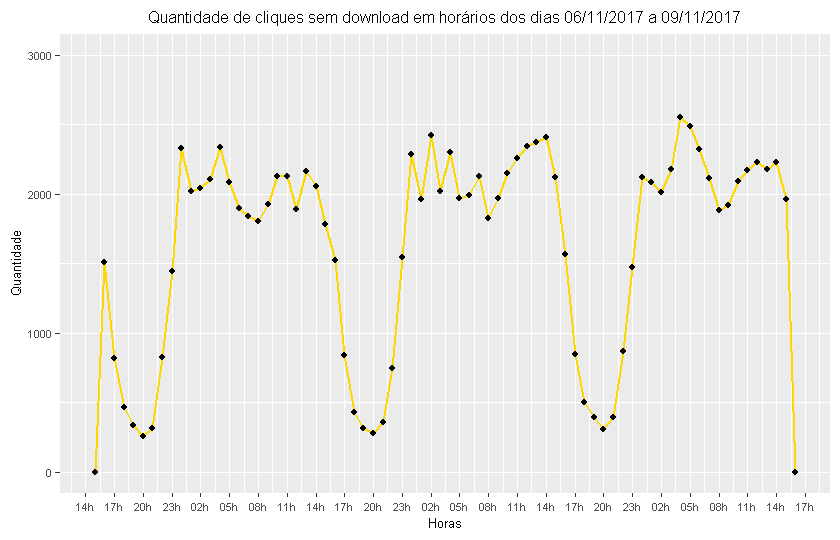

In [21]:
g6 <- ggplot(df_frequencia4, aes(x = data_horario2, y = frequencia_cliques)) +
    geom_line(size = 0.7,colour = 'gold') +                    
    geom_point(size = 1.3, colour = 'black') +
    scale_x_datetime(labels = date_format(format = '%Hh', tz = "UTC"), date_breaks = "3 hours") +
    coord_cartesian(ylim = c(0, 3000)) +
    labs(x = 'Horas', y = 'Quantidade', 
         title = 'Quantidade de cliques sem download em horários dos dias 06/11/2017 a 09/11/2017') +
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8))

options(repr.plot.width = 7, repr.plot.height = 4.5)
g6

No gráfico precebe-se que ocorrem picos de cliques sem download das 00h00 às 14h00. Há um enorme crescimento de cliques sem download no período de 21h00 às 00h00 nos dias 6, 7 e 8 e uma queda no período de 15h00 às 20h00 nos dias 7 e 8.

In [22]:
# AGRUPAR POR HORA PARA SABER EM QUAL HORÁRIO SE TEM MAIS CLIQUES SEM DOWNLOADS
df_frequencia5 <- df_frequencia4 %>%
    separate (col = data_horario2, c ("data2", "hora"), sep = ' ', remove = TRUE)

df_frequencia6 <- df_frequencia5 %>%
             group_by(hora) %>%
             summarise(total_cliques = sum(frequencia_cliques))

df_frequencia7 <- df_frequencia6 %>%
     separate(col = hora, c ("hora", "s", "m"), sep = ':', remove = TRUE) %>%
     select(hora, total_cliques)

head(df_frequencia7, 5)

hora,total_cliques
00,6739
01,6074
02,6482
03,6308
04,7195


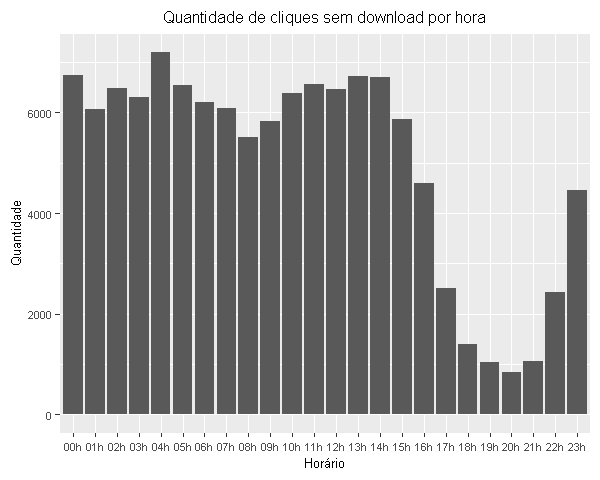

In [23]:
# HORÁRIOS COM MAIOR VOLUME DE CLIQUES SEM DOWNLOAD NOS TRÊS DIAS
g7 <- ggplot(df_frequencia7, aes(x = paste0(hora,"h"), y = total_cliques)) +
     geom_bar(stat ="identity") +
     labs(x = 'Horário', y = 'Quantidade', title = 'Quantidade de cliques sem download por hora') +
     theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 8))

options(repr.plot.width = 5, repr.plot.height = 4)
g7

Nos horários de 00h00 até as 14h00 é quando mais se tem cliques sem download.

#### **SEPARAR DADOS DE TREINO E TESTE**

In [24]:
set.seed(1908)

In [25]:
split <- sample.split(df_talkingdata$classe, SplitRatio = 0.8)
dados_treino <- subset(df_talkingdata, split == TRUE)
dados_teste <- subset(df_talkingdata, split == FALSE )

In [26]:
# DADOS TREINO 80%
str(dados_treino)

Classes 'data.table' and 'data.frame':	192000 obs. of  8 variables:
 $ ip              : int  191117 10833 6534 130391 286692 216604 48227 347674 1462 191880 ...
 $ app             : int  18 20 9 10 190 19 12 19 8 12 ...
 $ dispositivo     : int  1 1 1 1 1 129 1 0 1 1 ...
 $ so              : int  10 10 13 61 18 24 32 24 19 13 ...
 $ canal           : int  376 259 489 113 213 213 259 213 145 481 ...
 $ horario_clique  : POSIXct, format: "2017-11-07 08:10:07" "2017-11-07 10:21:18" ...
 $ horario_download: POSIXct, format: NA NA ...
 $ classe          : int  0 0 0 1 1 1 0 1 1 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [27]:
# DADOS TESTE 20%
str(dados_teste)

Classes 'data.table' and 'data.frame':	48000 obs. of  8 variables:
 $ ip              : int  159048 113682 119726 108341 212742 48170 5314 53454 187343 140556 ...
 $ app             : int  39 6 3 72 19 72 9 2 10 19 ...
 $ dispositivo     : int  1 1 1 1 21 1 2 1 1 0 ...
 $ so              : int  14 17 13 25 24 18 13 20 43 50 ...
 $ canal           : int  213 459 489 101 213 101 442 236 113 282 ...
 $ horario_clique  : POSIXct, format: "2017-11-07 02:49:38" "2017-11-08 05:03:44" ...
 $ horario_download: POSIXct, format: "2017-11-07 02:54:44" NA ...
 $ classe          : int  1 0 0 1 1 1 0 0 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [28]:
# REMOVER AS VARIÁVEIS COM DATAS 
dados_treino <- dados_treino[, c(1:5, 8)]
dados_treino <- as.data.frame(dados_treino)
dados_teste <- dados_teste[, c(1:5, 8)]
dados_teste <- as.data.frame(dados_teste)

In [29]:
str(dados_treino)

'data.frame':	192000 obs. of  6 variables:
 $ ip         : int  191117 10833 6534 130391 286692 216604 48227 347674 1462 191880 ...
 $ app        : int  18 20 9 10 190 19 12 19 8 12 ...
 $ dispositivo: int  1 1 1 1 1 129 1 0 1 1 ...
 $ so         : int  10 10 13 61 18 24 32 24 19 13 ...
 $ canal      : int  376 259 489 113 213 213 259 213 145 481 ...
 $ classe     : int  0 0 0 1 1 1 0 1 1 0 ...


In [30]:
str(dados_teste)

'data.frame':	48000 obs. of  6 variables:
 $ ip         : int  159048 113682 119726 108341 212742 48170 5314 53454 187343 140556 ...
 $ app        : int  39 6 3 72 19 72 9 2 10 19 ...
 $ dispositivo: int  1 1 1 1 21 1 2 1 1 0 ...
 $ so         : int  14 17 13 25 24 18 13 20 43 50 ...
 $ canal      : int  213 459 489 101 213 101 442 236 113 282 ...
 $ classe     : int  1 0 0 1 1 1 0 0 1 1 ...


### APRENDIZADO E AVALIAÇÃO DO MODELO

#### XGBOOST

In [31]:
# PREPARANDO DADOS DE TREINO E TESTE PARA O XGBOOST
x_treino = xgb.DMatrix(as.matrix(dados_treino[, c(1:5)]))
y_treino = dados_treino[, 6]

x_teste = xgb.DMatrix(as.matrix(dados_teste[, c(1:5)]))
y_teste = dados_teste[, 6]

In [32]:
# TRAIN CONTROL
trcontrol = trainControl(method = "cv",
                         number = 10,  
                         allowParallel = FALSE,
                         verboseIter = FALSE,
                         returnData = FALSE)

In [33]:
# GRID SEARCH
tune_grid <- expand.grid(nrounds = c(100, 500, 1000),
                          max_depth = 6,
                          eta = 0.1,
                          gamma = 0,
                          colsample_bytree = 0.7,
                          min_child_weight = 1,
                          subsample = 0.7)

In [34]:
set.seed(1908)

In [35]:
# TREINO 
xgb = train(x_treino, 
            y_treino,  
            trControl = trcontrol,
            tuneGrid = tune_grid,
            method = "xgbTree",                         
            objective = "binary:logistic")

print(xgb)

eXtreme Gradient Boosting 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 172800, 172800, 172800, 172800, 172800, 172800, ... 
Resampling results across tuning parameters:

  nrounds  RMSE       Rsquared   MAE      
   100     0.2492756  0.7516013  0.1295797
   500     0.2451929  0.7595254  0.1209511
  1000     0.2456198  0.7586991  0.1190574

Tuning parameter 'max_depth' was held constant at a value of 6
Tuning
 parameter 'min_child_weight' was held constant at a value of 1

Tuning parameter 'subsample' was held constant at a value of 0.7
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were nrounds = 500, max_depth = 6, eta
 = 0.1, gamma = 0, colsample_bytree = 0.7, min_child_weight = 1 and subsample
 = 0.7.


In [36]:
# PREVISÃO
prev_xgb = predict(xgb, x_teste, reshape = TRUE)

In [37]:
xgb_pred_class <- as.numeric(prev_xgb > 0.50)

In [38]:
confusionMatrix(as.factor(xgb_pred_class), as.factor(dados_teste$classe))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 23131  2929
         1   869 21071
                                               
               Accuracy : 0.9209               
                 95% CI : (0.9184, 0.9233)     
    No Information Rate : 0.5                  
    P-Value [Acc > NIR] : < 0.00000000000000022
                                               
                  Kappa : 0.8418               
                                               
 Mcnemar's Test P-Value : < 0.00000000000000022
                                               
            Sensitivity : 0.9638               
            Specificity : 0.8780               
         Pos Pred Value : 0.8876               
         Neg Pred Value : 0.9604               
             Prevalence : 0.5000               
         Detection Rate : 0.4819               
   Detection Prevalence : 0.5429               
      Balanced Accuracy : 0.9209               
              

In [39]:
source("metricas-classificacao.R")

In [40]:
metricas_class(0, table(previsto = as.factor(xgb_pred_class), referencia = as.factor(dados_teste$classe)), "Métricas XGBoost")

Métricas XGBoost 
 
Acuracia (Accuracy)          = 0.9209 
Recall (Sensitivity)         = 0.9638 
Precisao (Precision)         = 0.8876 
F1 Score (F-Score)           = 0.9241 
Especificidade (Specificity) = 0.878

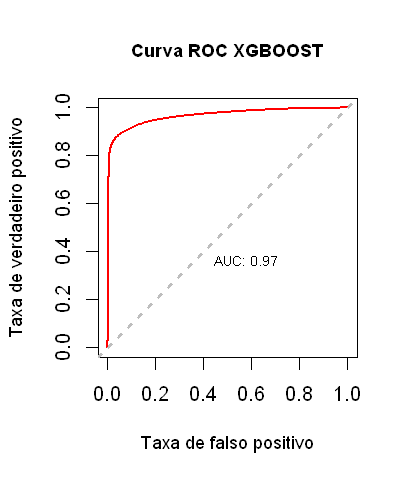

In [41]:
# CURVA ROC E AREA UNDER CURVE - AUC
prediction1 <- prediction(prev_xgb, as.factor(dados_teste$classe))
tpr_fpr_xgb <- performance(prediction1, "tpr","fpr")
auc_xgb <- performance(prediction1, "auc")
auc_xgb <- round(unlist(slot(auc_xgb, "y.values")), 2)

options(repr.plot.width = 3.4, repr.plot.height = 4)
plot(tpr_fpr_xgb, col = rainbow(9), 
     xlab = "Taxa de falso positivo", 
     ylab = "Taxa de verdadeiro positivo",
     main = "Curva ROC XGBOOST", 
     cex.lab = .9,   
     cex.main = .9,  
     lwd = 2 )
abline(a = 0, b = 1, lwd = 3, lty = 3, col = "gray")
legend(0.4, 0.4, legend = c(paste0("AUC: ", auc_xgb)), cex = 0.7, bty = "n", box.col = "white")

In [42]:
# TRANSFORMAR AS VARIÁVEIS PARA FACTOR PARA UTILIZAÇÃO DOS ALGORITMOS KNN E NAIVE BAYES
dados_treino$classe <- as.factor(dados_treino$classe)
dados_treino$ip <- as.factor(dados_treino$ip)
dados_treino$app <- as.factor(dados_treino$app)
dados_treino$dispositivo <- as.factor(dados_treino$dispositivo)
dados_treino$so <- as.factor(dados_treino$so)
dados_treino$canal <- as.factor(dados_treino$canal)

In [43]:
dados_teste$classe <- as.factor(dados_teste$classe)
dados_teste$ip <- as.factor(dados_teste$ip)
dados_teste$app <- as.factor(dados_teste$app)
dados_teste$dispositivo <- as.factor(dados_teste$dispositivo)
dados_teste$so <- as.factor(dados_teste$so)
dados_teste$canal <- as.factor(dados_teste$canal)

#### K - NEAREST NEIGHBOR

In [44]:
knn <- knn(train = dados_treino[, 1:5], test = dados_teste[, 1:5], cl = dados_treino[, 6], k = 5, prob = TRUE)

In [45]:
probabilidades <- attr(knn, "prob")

In [46]:
confusionMatrix(knn, dados_teste$classe)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 19475  5993
         1  4525 18007
                                               
               Accuracy : 0.7809               
                 95% CI : (0.7771, 0.7846)     
    No Information Rate : 0.5                  
    P-Value [Acc > NIR] : < 0.00000000000000022
                                               
                  Kappa : 0.5618               
                                               
 Mcnemar's Test P-Value : < 0.00000000000000022
                                               
            Sensitivity : 0.8115               
            Specificity : 0.7503               
         Pos Pred Value : 0.7647               
         Neg Pred Value : 0.7992               
             Prevalence : 0.5000               
         Detection Rate : 0.4057               
   Detection Prevalence : 0.5306               
      Balanced Accuracy : 0.7809               
              

In [47]:
metricas_class(0, table(previsto = knn, referencia = dados_teste$classe), "Métricas K-Nearest Neighbor")

Métricas K-Nearest Neighbor 
 
Acuracia (Accuracy)          = 0.7809 
Recall (Sensitivity)         = 0.8115 
Precisao (Precision)         = 0.7647 
F1 Score (F-Score)           = 0.7874 
Especificidade (Specificity) = 0.7503

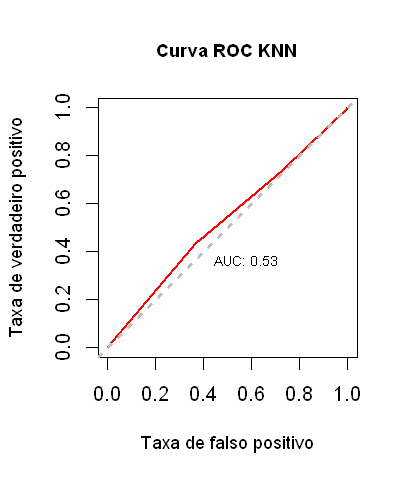

In [48]:
# CURVA ROC E AREA UNDER CURVE - AUC
prediction1 <- prediction(probabilidades, dados_teste$classe)
tpr_fpr_knn <- performance(prediction1, "tpr","fpr")
auc_knn <- performance(prediction1, "auc")
auc_knn <- round(unlist(slot(auc_knn, "y.values")), 2)

options(repr.plot.width = 3.4, repr.plot.height = 4)
plot(tpr_fpr_knn, col = rainbow(9), 
     xlab = "Taxa de falso positivo", 
     ylab = "Taxa de verdadeiro positivo",
     main = "Curva ROC KNN", 
     cex.lab = .9,   
     cex.main = .9,  
     lwd = 2 )
abline(a = 0, b = 1, lwd = 3, lty = 3, col = "gray")
legend(0.4, 0.4, legend = c(paste0("AUC: ", auc_knn)), cex = 0.7, bty = "n", box.col = "white")

#### NAIVE BAYES

In [49]:
nb <- naiveBayes(classe ~ ip + app + dispositivo + so + canal, dados_treino, laplace = 1)

In [50]:
# PREVISÃO DAS CLASSES
prev_nb <- predict(nb, dados_teste, type = "class")

In [51]:
# PREVISÃO DAS PROBABILIDADES DAS CLASSES
prev_nb_prob <- predict(nb, dados_teste, type = "raw")

In [52]:
confusionMatrix(prev_nb, dados_teste$classe)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 23469  3976
         1   531 20024
                                               
               Accuracy : 0.9061               
                 95% CI : (0.9035, 0.9087)     
    No Information Rate : 0.5                  
    P-Value [Acc > NIR] : < 0.00000000000000022
                                               
                  Kappa : 0.8122               
                                               
 Mcnemar's Test P-Value : < 0.00000000000000022
                                               
            Sensitivity : 0.9779               
            Specificity : 0.8343               
         Pos Pred Value : 0.8551               
         Neg Pred Value : 0.9742               
             Prevalence : 0.5000               
         Detection Rate : 0.4889               
   Detection Prevalence : 0.5718               
      Balanced Accuracy : 0.9061               
              

In [53]:
metricas_class(0, table(previsto = prev_nb, referencia = dados_teste$classe), "Métricas Naive Bayes")

Métricas Naive Bayes 
 
Acuracia (Accuracy)          = 0.9061 
Recall (Sensitivity)         = 0.9779 
Precisao (Precision)         = 0.8551 
F1 Score (F-Score)           = 0.9124 
Especificidade (Specificity) = 0.8343

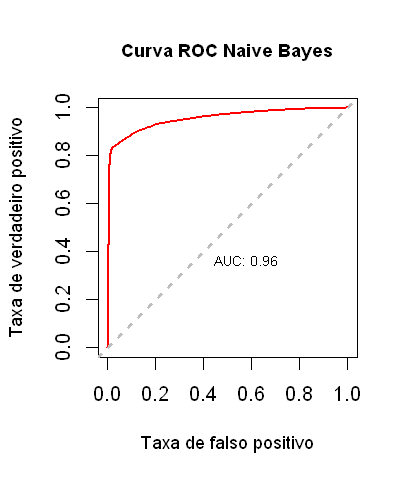

In [54]:
# CURVA ROC E AREA UNDER CURVE - AUC
prediction2 <- prediction(prev_nb_prob[, 2], dados_teste$classe)
tpr_fpr_nb <- performance(prediction2, "tpr","fpr")
auc_nb <- performance(prediction2, "auc")
auc_nb <- round(unlist(slot(auc_nb, "y.values")), 2)

options(repr.plot.width = 3.4, repr.plot.height = 4)
plot(tpr_fpr_nb, col = rainbow(9), 
     xlab = "Taxa de falso positivo", 
     ylab = "Taxa de verdadeiro positivo",
     main = "Curva ROC Naive Bayes", 
     cex.lab = .9,   
     cex.main = .9,  
     lwd = 2 )
abline(a = 0, b = 1, lwd = 3, lty = 3, col = "gray")
legend(0.4, 0.4, legend = c(paste0("AUC: ", auc_nb)), cex = 0.7, bty = "n", box.col = "white")

#### CONCLUSÃO

As amostras coletadas do dataset train.csv permitiram a montagem de um dataset para treino e teste de forma balanceada com os dados originais sem que fosse necessário recorrer à funções que gerassem dados sintéticos. Como o dataset train.csv do Kaggle possui em sua maioria instâncias da classe 0 (aplicativo não baixado) sendo quase 100% do dataset, foi realizada a coleta de dados de cada classe para que um dataset fosse montado de forma balanceada.

Na etapa de aprendizado foram utilizados os algoritmos Extreme Gradient Boosting (XGBoost), K-Nearest Neighbor (K-NN) e Naive Bayes. O XGBoost obteve o melhor resultado.

Resultados do XGBoost:

- O modelo atingiu uma **acurácia de 0.9209**. Das 48.000 instâncias do dataset de teste, o modelo classificou corretamente 44.202.
- O modelo acertou 23.131 e errou 869 da soma entre verdadeiros positivos e falsos negativos, obtendo um **recall de 0.9638**, o que é importante para o problema, pois é importante minimizar os falsos negativos para que seus IPs não sejam colocados na lista negra.
- Quanto a classe positiva, o modelo acertou 23.131 (verdadeiros positivos) do total de verdadeiros positivos somados a falsos positivos. Uma **precisão de 0.8878**. A precisão mostra a proporção de classificação correta da classe positiva dentre todos preditos como positivos. 
- Quanto a classe negativa, o modelo acertou 21.071 (verdadeiros negativos) do total de verdadeiros negativos somados a falsos positivos. Uma **especificidade de 0.878**. A especificidade mostra a capacidade do modelo de detectar resultados verdadeiros negativos. Por outro lado, tem-se o recall com **0.9638**, que mostra a capacidade do método de detectar resultados verdadeiros positivos.
- A **média harmônica** entre precisão e recall foi de **0.9241**.
- A curva ROC com seus dois parâmetros, taxa de verdadeiro positivo (sensibilidade) e taxa de falso positivo ou probabilidade de alarme falso (1 — Specificity), mostrou que o desempenho do modelo com XGBoost foi bom com um **AUC de 0.97**.